# TO DO
1. Figure out dataset
2. Break down into individual characters
3. Form corpus from dataset for input and output characters
4. Assign a number to each character
5. Model will have an embedding so it will handle it
6. Output will be a bunch of integers so we will have to decode it

In [21]:
import tarfile
import os
import pandas as pd
import keras
import numpy as np
from keras import layers
from keras.layers import LSTM, Dense, Embedding, Input
from keras.models import Model
from keras.utils.vis_utils import plot_model

In [3]:
!wget -nc https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar

if not os.path.isdir('/content/dakshina_dataset_v1.0'):
  tarfile.open("/content/dakshina_dataset_v1.0.tar").extractall() 

--2021-04-26 11:31:44--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G  24.8MB/s    in 24s     

2021-04-26 11:32:08 (80.7 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



# Loading Data

In [4]:
class data_loader():

  @staticmethod
  def _load_raw_df(languages = ["hi", "mr"]):
    lex = dict()
    lex['train'], lex['val'], lex['test'] = [], [], [] 
    column_names = ['input', 'output', 'count']
    
    for la in languages:
      lex['train'].append(pd.read_csv('/content/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.train.tsv', sep='\t', header=None, names=column_names))
      lex['val'].append(pd.read_csv('/content/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.dev.tsv', sep='\t', header=None, names=column_names))
      lex['test'].append(pd.read_csv('/content/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.test.tsv', sep='\t', header=None, names=column_names))

    lex['train'] = pd.concat(lex['train'])
    lex['val'] = pd.concat(lex['val'])
    lex['test'] = pd.concat(lex['test'])

    return lex    

  @staticmethod
  def _make_final_df(lex):
    
    for div in ['train', 'val', 'test']:
    
      # removing non max transliterations
      idx = lex[div].groupby(['input'])['count'].transform(max) == lex[div]['count']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # calclulating difference in lengths of various transliterations
      lex[div]['input_len'] = lex[div].apply(lambda x: len(str(x['input'])), axis=1)
      lex[div]['output_len'] = lex[div].apply(lambda y: len(str(y['output'])), axis=1)
      lex[div]['mod_dif'] = lex[div].apply(lambda z: abs(z['input_len'] - z['output_len']), axis=1) 

      # removing transliterations that vary by a lot in length
      idx = lex[div].groupby(['input'])['mod_dif'].transform(min) == lex[div]['mod_dif']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # removing duplicates if any remain
      lex[div].drop_duplicates(subset='input', keep='first', inplace=True)

      # removing redundant columns
      lex[div].drop(labels=['count', 'input_len', 'output_len', 'mod_dif'], inplace=True, axis=1)

    return lex

  @staticmethod
  def _generate_batch(X, y, data_dict, num_decoder_tokens, batch_size = 1):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, data_dict['max_source_length']),dtype='float32')
            decoder_input_data = np.zeros((batch_size, data_dict['max_target_length']),dtype='float32')
            decoder_target_data = np.zeros((batch_size, data_dict['max_target_length'], num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text):
                  encoder_input_data[i, t] = word
                for t, word in enumerate(target_text):
                    if t<len(target_text)-1:
                        decoder_input_data[i, t] = word # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        #print(word)
                        decoder_target_data[i, t - 1, word] = 1.
                    
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [5]:
class Tokenizer:

  def __init__(self, df):

    self.start_token = '<STR>'
    self.stop_token = '<STP>'
    self.unknown_token = '<UNK>'

    self.input_corpus = [self.start_token, self.stop_token, self.unknown_token]
    self.output_corpus = [self.start_token, self.stop_token, self.unknown_token]

    input_words = df.input.tolist()
    output_words = df.output.tolist()

    for word in input_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.input_corpus:
          self.input_corpus.append(token)

    for word in output_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.output_corpus:
          self.output_corpus.append(token)
    
    self.encode_dict_input = {self.input_corpus[i] : i+1 for i in range(len(self.input_corpus))}
    self.decode_dict_input = {k:v for v,k in self.encode_dict_input.items()}
    
    self.encode_dict_output = {self.output_corpus[i] : i+1 for i in range(len(self.output_corpus))}
    self.decode_dict_output = {k:v for v,k in self.encode_dict_output.items()}

  # takes in lists of words and returns lists of integers
  def encode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for word in X:
        word = str(word)
        # integer_list = [self.encode_dict_input[self.start_token]] + [self.encode_dict_input.get(token, self.encode_dict_input[self.unknown_token]) for token in word] + [self.encode_dict_input[self.stop_token]]
        integer_list =np.array([self.encode_dict_input.get(token, self.encode_dict_input[self.unknown_token]) for token in word])
        input_list.append(integer_list)
      
      return input_list
    
    if (mode=='output'):
      output_list = []
      for word in X:
        word = str(word)
        integer_list = np.array([self.encode_dict_output[self.start_token]] + [self.encode_dict_output.get(token, self.encode_dict_output[self.unknown_token]) for token in word] + [self.encode_dict_output[self.stop_token]])
        output_list.append(integer_list)
      
      return output_list
    

  # takes in lists of integers and returns lists of words
  def decode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for integers in X:
        token_list = [self.decode_dict_input.get(integer, '0') for integer in integers] 
        input_list.append(''.join(token_list))
      
      return input_list

    if (mode=='output'):
      output_list = []
      for integers in X:
        token_list = [self.decode_dict_output.get(integer, '0') for integer in integers[1:-1]] 
        output_list.append(''.join(token_list))
      
      return output_list

In [7]:
def return_data_dict(languages=['hi', 'mr'], batch_size=32):

  lex = data_loader._load_raw_df(languages)
  lex = data_loader._make_final_df(lex)

  data_dict = dict()

  df_train = lex['train']
  df_val = lex['val']
  df_test = lex['test']

  tk = Tokenizer(df_train)

  data_dict['in_size'] = len(tk.input_corpus) + 1
  data_dict['out_size'] = len(tk.output_corpus) + 1

  X_train = tk.encode(df_train.input.tolist(), mode='input')
  Y_train = tk.encode(df_train.output.tolist(), mode='output')
  X_val = tk.encode(df_val.input.tolist(), mode='input')
  Y_val = tk.encode(df_val.output.tolist(), mode='output')
  X_test = tk.encode(df_test.input.tolist(), mode='input')
  Y_test = tk.encode(df_test.output.tolist(), mode='output')

  max_source_length = np.max(np.array([len(x) for x in X_train]))
  max_target_length = np.max(np.array([len(x) for x in Y_train]))

  data_dict['train'], data_dict['val'], data_dict['test']= dict(), dict(), dict()

  data_dict['train']['df'] = df_train
  data_dict['val']['df'] = df_val
  data_dict['test']['df'] = df_test

  data_dict['train']['max_source_length'] = np.max(np.array([len(x) for x in X_train]))
  data_dict['train']['max_target_length'] = np.max(np.array([len(x) for x in Y_train]))
  data_dict['val']['max_source_length'] = np.max(np.array([len(x) for x in X_val]))
  data_dict['val']['max_target_length'] = np.max(np.array([len(x) for x in Y_test]))
  data_dict['test']['max_source_length'] = np.max(np.array([len(x) for x in X_test]))
  data_dict['test']['max_target_length'] = np.max(np.array([len(x) for x in Y_test]))

  data_dict['train']['batch'] = data_loader._generate_batch(X_train, Y_train, data_dict['train'], data_dict['out_size'], batch_size)
  data_dict['val']['batch'] = data_loader._generate_batch(X_val, Y_val, data_dict['val'], data_dict['out_size'], batch_size)
  data_dict['test']['batch'] = data_loader._generate_batch(X_test, Y_test, data_dict['test'], data_dict['out_size'], batch_size)  
  
  data_dict['tokenizer'] = tk

  return data_dict

In [8]:
data_dict = return_data_dict()

In [9]:
data = dict()
# data['train'] = dict()
# data['train']['X'] = X_train
# data['train']['Y'] = Y_train
# data['in_size'] = len(tk.input_corpus) + 1
# data['out_size'] = len(tk.output_corpus) + 1
# num_decoder_tokens = data['out_size'] 
# max_source_length = np.max(np.array([len(x) for x in X_train]))
# max_target_length = np.max(np.array([len(x) for x in Y_train]))

# Question 1


In [ ]:
class BeamSearchCallBack(keras.callbacks.Callback):
  pass 

In [91]:
class rnn():

  def __init__(self, params):
    
    num_encode_layers = params['num_encode_layers']
    num_decode_layers = params['num_decode_layers']
    data_dict = params['data_dict']
    in_size = params['data_dict']['in_size']
    out_size = params['data_dict']['out_size']
    cell_type = params['cell_type']
    dropout = params['dropout']
    embed_size = params['embed_size']
    rep_size = params['rep_size']
        
    ###################### ENCODER NETWORK ######################
    
    encoder_inputs = Input(shape=(None,))
    x = Embedding(in_size, embed_size ,mask_zero=True)(encoder_inputs)

    encoder_layers = []
    
    for j in range(num_encode_layers-1) :   
      curr_layer = getattr(layers, cell_type)(rep_size, dropout=dropout, return_sequences=True)
      encoder_layers.append(curr_layer)
      x = curr_layer(x)

    curr_layer = getattr(layers, cell_type)(rep_size, dropout=dropout, return_state=True)
    encoder_layers.append(curr_layer)
    x, *encoder_states = curr_layer(x)

    ###################### DECODER NETWORK ######################

    decoder_inputs = Input(shape=(None,))

    decoder_embedding =  Embedding(out_size, embed_size, mask_zero=True)
    x = decoder_embedding(decoder_inputs)

    decoder_layers = []    
    
    for j in range(num_decode_layers) :
      curr_layer = getattr(layers, cell_type)(rep_size,dropout=dropout,return_state=True, return_sequences=True)
      decoder_layers.append(curr_layer)
      x, *decoder_states = curr_layer(x, initial_state=encoder_states)

    decoder_dense = Dense(units=out_size, activation='softmax')
    decoder_outputs = decoder_dense(x)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    self.model = model
    self.encoder_inputs = encoder_inputs
    self.encoder_layers = encoder_layers
    self.decoder_inputs = decoder_inputs
    self.decoder_embedding = decoder_embedding
    self.decoder_layers = decoder_layers
    self.decoder_dense = decoder_dense
    self.encoder_states = encoder_states
    self.params = params

  def compile_and_fit(self, data_dict, params):

    self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    summary = self.model.summary()
    plot = plot_model(self.model, show_shapes=True)
    
    train_samples = len(data_dict['train']['df']) # Total Training samples
    val_samples = len(data_dict['val']['df'])    # Total validation or test samples
    batch_size = params['batch_size']
    num_epochs = params['num_epochs']
    
    run_details = self.model.fit_generator(generator = data_dict['train']['batch'],
                                            steps_per_epoch = train_samples//batch_size,
                                            epochs=num_epochs,
                                            callbacks=[]
                                            )

    # train_ds, val_ds = data['train'], data['val']
    # optimizer, epochs = params['optimizer'], params['num_epochs']
    
    return {
        'run_details' : run_details
    }



In [97]:
params = {
    'num_encode_layers' : 4,
    'num_decode_layers' : 4,
    'cell_type' : 'GRU', # SimpleRNN, GRU
    'rep_size' : 20,
    'embed_size' : 20,
    'dropout' : 0,
    'num_epochs' : 10,
    'data_dict' : data_dict,
    'batch_size' : 32
}

In [98]:
network = rnn(params)

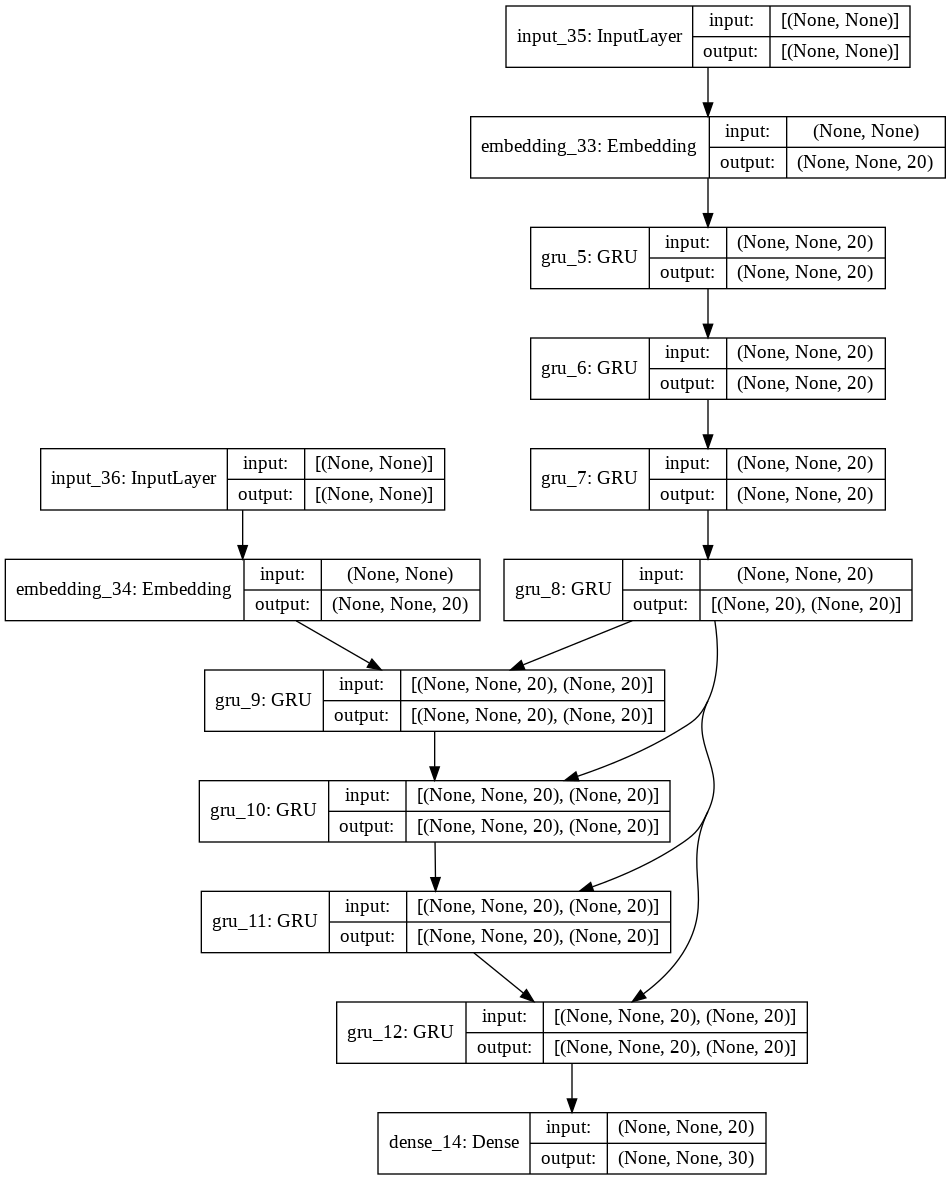

In [99]:
plot_model(network.model, show_shapes=True)

In [100]:
network.compile_and_fit(data_dict, params)

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, None, 20)     1440        input_35[0][0]                   
__________________________________________________________________________________________________
gru_5 (GRU)                     (None, None, 20)     2520        embedding_33[0][0]               
__________________________________________________________________________________________________
gru_6 (GRU)                     (None, None, 20)     2520        gru_5[0][0]                      
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1420/1420 [==============================] - 112s 57ms/step - loss: 1.0000 - acc: 0.2526
Epoch 2/10
1420/1420 [==============================] - 81s 57ms/step - loss: 0.8278 - acc: 0.3367
Epoch 3/10
1420/1420 [==============================] - 80s 56ms/step - loss: 0.8004 - acc: 0.3489
Epoch 4/10
1420/1420 [==============================] - 81s 57ms/step - loss: 0.7755 - acc: 0.3673
Epoch 5/10
 872/1420 [=================>............] - ETA: 30s - loss: 0.7487 - acc: 0.3736

KeyboardInterrupt: ignored

In [ ]:
encoder_inputs = Input(shape=(None,))
x = Embedding(data_dict['in_size'], 64,mask_zero=True)(encoder_inputs)
x = LSTM(units=256,return_sequences=True)(x)
x, *encoder_states = LSTM(units=256,
                           return_state=True)(x)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

decoder_embedding =  Embedding(data_dict['out_size'], 64,mask_zero=True)
x = decoder_embedding(decoder_inputs)

decoder_LSTM = LSTM(units=256, return_sequences=True, return_state=True)
x, *decoder_states = decoder_LSTM(x, initial_state=encoder_states)

decoder_dense = Dense(units=data_dict['out_size'], activation='softmax')
decoder_outputs = decoder_dense(x)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [22]:
encoder_model = Model(encoder_inputs, encoder_states)
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]
# Get the embeddings of the decoder sequence
dec_emb2 = decoder_embedding(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs_2, *decoder_states_2 = decoder_LSTM(dec_emb2
                                                    ,initial_state=decoder_state_input
                                                    )
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs_2 = decoder_dense(decoder_outputs_2)
# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_state_input,
    [decoder_outputs_2] + decoder_states_2)

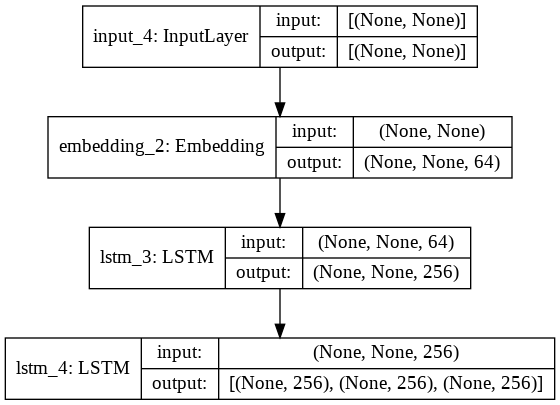

In [26]:
plot_model(encoder_model,show_shapes=True)

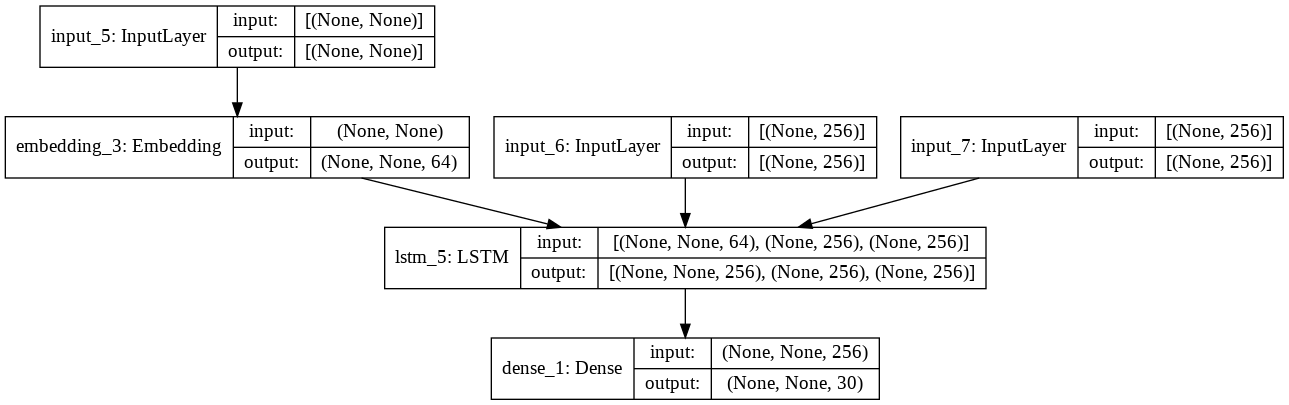

In [25]:
plot_model(decoder_model,show_shapes=True)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of 
    #target sequence with the start character.
    target_seq[0, 0] = 1
# Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    chars = [1]
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
# Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 2 :
          stop_condition = True
        chars.append(sampled_token_index)
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
# Update states
        states_value = [h, c]
    return tk.decode([chars],'output')[0]

In [ ]:
test_gen = generate_batch(X_test, Y_test, batch_size = 1)
k=-1

In [ ]:
x1 = tk.encode(['टोप्पर​'])
x1

In [ ]:
decode_sequence(x1)

In [ ]:
lex['test'].input.tolist()[k]

In [ ]:
k += 1
(input_seq, actual_output), _ = next(test_gen)
# print(input_seq)
decoded_sentence = decode_sequence(input_seq)
print('Input Source sentence:', tk.decode([X_test[k]])[0] )
print('Actual Target Translation:', tk.decode([Y_test[k]],mode='output')[0])
print('Predicted Target Translation:', decoded_sentence)

# Romanized

In [ ]:
ta_rom = dict()
ta_rom['rejoined'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.tsv', sep='\t', header=None, error_bad_lines=False)
ta_rom['rejoined_aligned_cased'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.aligned.cased_nopunct.tsv', sep='\t', header=None, error_bad_lines=False) 
ta_rom['rejoined_aligned'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.aligned.tsv', sep='\t', header=None, error_bad_lines=False)
ta_rom['split'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.split.tsv', sep='\t', header=None, error_bad_lines=False)

In [ ]:
list(ta_rom['rejoined'].iloc[0, 0])[:10]

In [ ]:
ta_rom['rejoined_aligned_cased']

In [ ]:
ta_rom['rejoined_aligned']

In [ ]:
ta_rom['split']